# Plotting Geological (poly/line) Data with ModEM Phase Tensors

This notebook demonstrates how to plot geological polygon/line data overlain by ModEM phase tensors. Polygonal data in a given shapefile can be coloured according to a given lookup table.

In [1]:
# Add mtpy folder to python path. This may not be necessary 
# depending on how mtpy was installed.
import sys

#sys.path.append('/path/to/mtpy')
sys.path.append('/home/rakib/work/ausLAMP/codes/mtGeoMtpy/')

In [29]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator
from matplotlib import colors
import matplotlib.cm as cm

from matplotlib.patches import Polygon as MPLPolygon
from mpl_toolkits.basemap import pyproj
from mpl_toolkits.basemap import Basemap

from netCDF4 import Dataset

# Import required classes from key mtpy modules 
from mtpy.imaging2.geology import Geology
from mtpy.imaging2.modem_ptensors import ModEM_ptensors

%matplotlib inline

## Load Geological Data

* The **Geology** class is used to load both polygon and line data from two separate shapefiles

In [3]:
polySFN = '../../examples/data/geology/NT_LithInterp_2500K_region.shp'
lineSFN = '../../examples/data/geology/NT_Fault_2500K_polyline.shp'
lutFN = '../../examples/data/geology/colour_lut.txt'


polyData = Geology(polySFN)
lineData = Geology(lineSFN)

## Load ModEM Phase Tensors

The **ModEM_ptensors** class is used to load a ModEM data file.

In [12]:
modemFN = '../../examples/data/ModEM_files/ModEM_Data_im2.dat'

modemPT = ModEM_ptensors(modemFN)

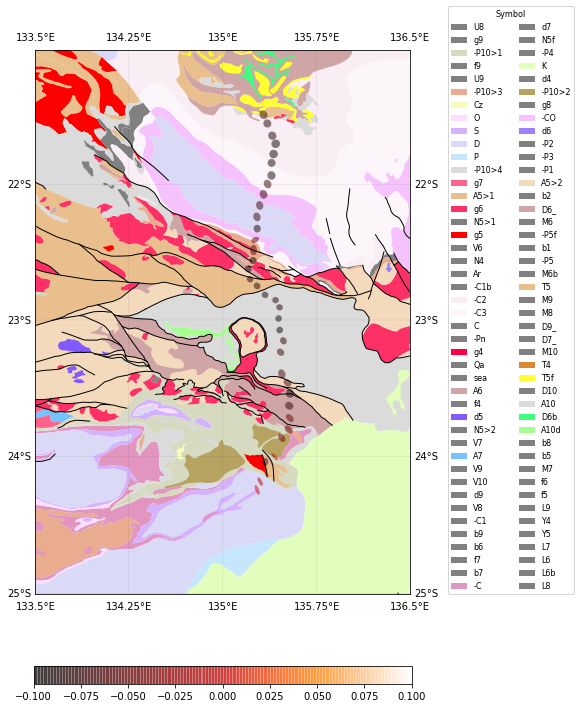

In [34]:
# set plot extents and dimensions
minLat = -25
maxLat = -21
minLon = 133.5
maxLon = 136.5

fig, ax = plt.subplots(figsize=(10,10))

m = Basemap(resolution='c', # c, l, i, h, f or None
            ax=ax,
            projection='merc',
            lat_0=-22, lon_0=135,
            llcrnrlon=minLon, llcrnrlat=minLat, urcrnrlon=maxLon, urcrnrlat=maxLat)

# draw lat-lon grids
m.drawparallels(np.linspace(minLat, maxLat, 5), labels=[1,1,0,0], linewidth=0.1)
m.drawmeridians(np.linspace(minLon, maxLon, 5), labels=[0,0,1,1], linewidth=0.1)

# plot geology ===================================================================

# plot polygons using a color lookup table
h,l = polyData.plot(ax, m, lutfn=lutFN, alpha=1)

# plot line data
lineData.plot(ax, m, alpha=1, color='k', linewidth=1.0)

# create legend including all symbols used in the plot
leg = ax.legend(h, l, loc=3,
                  bbox_to_anchor=(1.1, 0),
                  borderaxespad=0,
                  handlelength=2,
                  title= 'Symbol',
                  ncol=2,
                  fontsize=8)
leg.get_title().set_fontsize(8)

# plot phase tensors =============================================================
# fetch attribute to color phase tensor ellipses with
cmapAttrib = modemPT.get_period_attributes(16, 'ellipticity')
sm = cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=np.min(cmapAttrib), 
                                                 vmax=np.max(cmapAttrib)),  
                       cmap='gist_heat')
# extract color values from colormap
cvals = sm.cmap(cmapAttrib)
modemPT.plot(ax, m, periodIdx=16, cvals=cvals, alpha=0.5)

# show colormap
cbax = fig.add_axes([0.25,0,0.525,.025])
cbar = mpl.colorbar.ColorbarBase(cbax, cmap=sm.cmap,
                                 norm = sm.norm,
                                 orientation='horizontal',
                                 alpha=0.5)
#cbar.solids.set_edgecolor("face", alpha=0.5)

plt.savefig('/tmp/a.png', dpi=300)

## Load Magnetics

In [40]:
# load magnetics 
magFN = '../../examples/data/magnetics/magLowRes.nc'
mag = Dataset(magFN)

maglons = mag.variables['lon'][:]
maglats = mag.variables['lat'][:]
magvs = mag.variables['z'][:]

maglons, maglats = np.meshgrid(maglons, maglats)

# project lats and lons
magpx, magpy = m(maglons, maglats)


## Show Raster Data Overlain by Phase Tensors


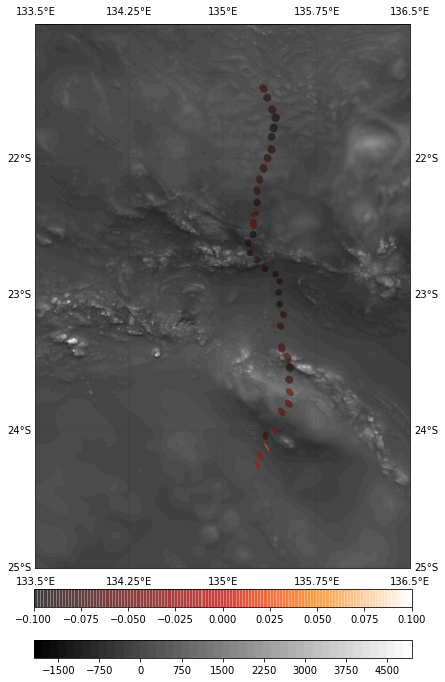

In [59]:
# plot magnetics and phase tensors
# set plot extents and dimensions
minLat = -25
maxLat = -21
minLon = 133.5
maxLon = 136.5

fig, ax = plt.subplots(figsize=(10,10))

m = Basemap(resolution='c', # c, l, i, h, f or None
            ax=ax,
            projection='merc',
            lat_0=-22, lon_0=135,
            llcrnrlon=minLon, llcrnrlat=minLat, urcrnrlon=maxLon, urcrnrlat=maxLat)

# draw lat-lon grids
m.drawparallels(np.linspace(minLat, maxLat, 5), labels=[1,1,0,0], linewidth=0.1)
m.drawmeridians(np.linspace(minLon, maxLon, 5), labels=[0,0,1,1], linewidth=0.1)

# plot magnetics
c = m.contourf(magpx, magpy, magvs, 50, cmap='gray', rasterized=True)
cbax1 = fig.add_axes([0.25,0,0.525,0.025])
fig.colorbar(c, cbax1, orientation='horizontal')

# plot phase tensors
modemPT.plot(ax, m, periodIdx=16, cvals=cvals, alpha=0.5)
cbax2 = fig.add_axes([0.25,0.07,0.525,0.025])
cbar = mpl.colorbar.ColorbarBase(cbax2, cmap=sm.cmap,
                                 norm = sm.norm,
                                 orientation='horizontal',
                                 alpha=0.5)